In [29]:
import yfinance as yf
import pandas as pd
import os


In [30]:
if os.path.exists("nifty.csv"):
    nifty = pd.read_csv("nifty.csv", index_col=0)
else:
    nifty = yf.Ticker("^NSEI")
    nifty = nifty.history(period="max")
    nifty.to_csv("nifty.csv")

In [31]:
nifty.index = pd.to_datetime(nifty.index)

In [32]:
nifty

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-09-17 00:00:00+05:30,4518.450195,4549.049805,4482.850098,4494.649902,0,0.0,0.0
2007-09-18 00:00:00+05:30,4494.100098,4551.799805,4481.549805,4546.200195,0,0.0,0.0
2007-09-19 00:00:00+05:30,4550.250000,4739.000000,4550.250000,4732.350098,0,0.0,0.0
2007-09-20 00:00:00+05:30,4734.850098,4760.850098,4721.149902,4747.549805,0,0.0,0.0
2007-09-21 00:00:00+05:30,4752.950195,4855.700195,4733.700195,4837.549805,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-12 00:00:00+05:30,18595.050781,18633.599609,18559.750000,18601.500000,179500,0.0,0.0
2023-06-13 00:00:00+05:30,18631.800781,18728.900391,18631.800781,18716.150391,233200,0.0,0.0
2023-06-14 00:00:00+05:30,18744.599609,18769.699219,18690.000000,18755.900391,261400,0.0,0.0


<Axes: xlabel='Date'>

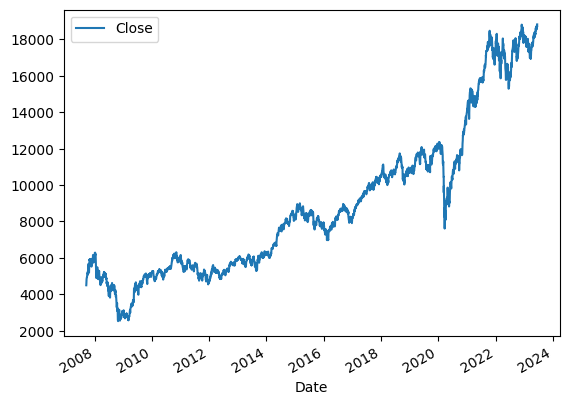

In [33]:
nifty.plot.line(y="Close", use_index=True)

In [34]:
del nifty["Dividends"]
del nifty["Stock Splits"]

In [35]:
nifty["Tomorrow"] = nifty["Close"].shift(-1)

In [36]:
nifty["Target"] = (nifty["Tomorrow"] > nifty["Close"]).astype(int)

In [37]:
nifty = nifty.loc["2007-09-17":].copy()

In [38]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, min_samples_split=250, random_state=1)

train = nifty.iloc[:-100]
test = nifty.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=250, n_estimators=1000, random_state=1)

In [39]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5306122448979592

<Axes: xlabel='Date'>

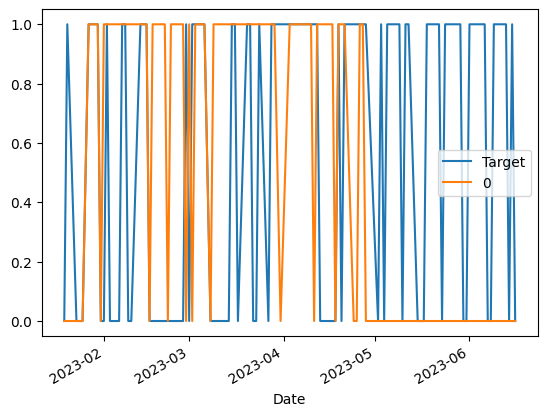

In [40]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [41]:
#BUILDING BACKTESTING SYSTEM

In [42]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [43]:
def backtest(data, model, predictors, start=2000, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [44]:
predictions = backtest(nifty, model, predictors)

In [46]:
predictions["Predictions"].value_counts()

Predictions
1    1038
0     822
Name: count, dtype: int64

In [47]:
#LOOKING AT PRECISION SCORE

In [48]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5443159922928709

In [49]:
#LOOKING AT PRECISION SCORE FOR MARKET GOING UP OR DOWN INDIVIDUALLY

In [50]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.541398
0    0.458602
Name: count, dtype: float64

In [51]:
#PROVIDING MODEL MEAN OF DIFFERENT TIMESPANS i.e. LAST 2 DAYS, LAST TRADING WEEK, LAST 3 MONTHS, LAST TRADING YEAR, LAST 4 TRADING YEARS

In [56]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = nifty.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    nifty[ratio_column] = nifty["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    nifty[trend_column] = nifty.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [57]:
nifty

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,gap_2,gap_5,gap_60,gap_250,gap_1000
Date,,,,,,,,,,,,,,,,,,,,,
2007-09-17 00:00:00+05:30,4518.450195,4549.049805,4482.850098,4494.649902,0,4546.200195,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-18 00:00:00+05:30,4494.100098,4551.799805,4481.549805,4546.200195,0,4732.350098,1,1.005702,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.005702,NaN,NaN,NaN,NaN
2007-09-19 00:00:00+05:30,4550.250000,4739.000000,4550.250000,4732.350098,0,4747.549805,1,1.020062,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.020062,NaN,NaN,NaN,NaN
2007-09-20 00:00:00+05:30,4734.850098,4760.850098,4721.149902,4747.549805,0,4837.549805,1,1.001603,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.001603,NaN,NaN,NaN,NaN
2007-09-21 00:00:00+05:30,4752.950195,4855.700195,4733.700195,4837.549805,0,4932.200195,1,1.009390,2.0,1.035510,...,NaN,NaN,NaN,NaN,NaN,1.009390,1.035510,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12 00:00:00+05:30,18595.050781,18633.599609,18559.750000,18601.500000,179500,18716.150391,1,1.001025,1.0,0.998740,...,39.0,1.057508,137.0,1.268323,544.0,1.001025,0.998740,1.038875,1.057508,1.268323
2023-06-13 00:00:00+05:30,18631.800781,18728.900391,18631.800781,18716.150391,233200,18755.900391,1,1.003072,2.0,1.003633,...,40.0,1.063485,137.0,1.275550,544.0,1.003072,1.003633,1.043653,1.063485,1.275550
2023-06-14 00:00:00+05:30,18744.599609,18769.699219,18690.000000,18755.900391,261400,18688.099609,0,1.001061,2.0,1.005446,...,41.0,1.065125,138.0,1.277659,545.0,1.001061,1.005446,1.044138,1.065125,1.277659


In [58]:
nifty = nifty.dropna(subset=nifty.columns[nifty.columns != "Tomorrow"])

In [59]:
nifty

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,gap_2,gap_5,gap_60,gap_250,gap_1000
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-13 00:00:00+05:30,5130.799805,5136.950195,5067.649902,5077.850098,0,5132.299805,1,0.997883,1.0,1.014789,...,23.0,0.911365,111.0,1.042939,510.0,0.997883,1.014789,0.992330,0.911365,1.042939
2011-10-14 00:00:00+05:30,5057.350098,5141.399902,5056.600098,5132.299805,0,5118.250000,0,1.005333,1.0,1.015754,...,24.0,0.921801,111.0,1.053995,510.0,1.005333,1.015754,1.004393,0.921801,1.053995
2011-10-17 00:00:00+05:30,5156.200195,5160.200195,5084.500000,5118.250000,0,5037.500000,0,0.998629,1.0,1.007444,...,23.0,0.919921,111.0,1.051026,509.0,0.998629,1.007444,1.003264,0.919921,1.051026
2011-10-18 00:00:00+05:30,5049.450195,5057.500000,5011.049805,5037.500000,0,5139.149902,1,0.992049,0.0,0.989091,...,23.0,0.906187,110.0,1.034383,508.0,0.992049,0.989091,0.989147,0.906187,1.034383
2011-10-19 00:00:00+05:30,5080.450195,5148.049805,5075.299805,5139.149902,0,5091.899902,0,1.009989,1.0,1.007477,...,24.0,0.925163,111.0,1.055190,508.0,1.009989,1.007477,1.010438,0.925163,1.055190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12 00:00:00+05:30,18595.050781,18633.599609,18559.750000,18601.500000,179500,18716.150391,1,1.001025,1.0,0.998740,...,39.0,1.057508,137.0,1.268323,544.0,1.001025,0.998740,1.038875,1.057508,1.268323
2023-06-13 00:00:00+05:30,18631.800781,18728.900391,18631.800781,18716.150391,233200,18755.900391,1,1.003072,2.0,1.003633,...,40.0,1.063485,137.0,1.275550,544.0,1.003072,1.003633,1.043653,1.063485,1.275550
2023-06-14 00:00:00+05:30,18744.599609,18769.699219,18690.000000,18755.900391,261400,18688.099609,0,1.001061,2.0,1.005446,...,41.0,1.065125,138.0,1.277659,545.0,1.001061,1.005446,1.044138,1.065125,1.277659


In [60]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [61]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [62]:
predictions = backtest(nifty, model, new_predictors)

In [63]:
predictions["Predictions"].value_counts()

Predictions
0.0    681
1.0    179
Name: count, dtype: int64

In [64]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6256983240223464

In [65]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.546512
0    0.453488
Name: count, dtype: float64

In [66]:
predictions

,Target,Predictions
Date,,
2019-12-31 00:00:00+05:30,1,0.0
2020-01-01 00:00:00+05:30,1,0.0
2020-01-02 00:00:00+05:30,0,0.0
2020-01-03 00:00:00+05:30,0,0.0
2020-01-06 00:00:00+05:30,1,0.0
...,...,...
2023-06-12 00:00:00+05:30,1,0.0
2023-06-13 00:00:00+05:30,1,0.0
2023-06-14 00:00:00+05:30,0,0.0
